# Mathematics for Data Science
Eric Eager
VP and Partner, SumerSports

In this virtual bootcamp, I will take you through some fundamental areas of data science - both theory and application - using my expertise in American football as a set of examples for you. 

This bootcamp will focus on three main areas of data science, and their theoretical underpinnings: exploratory data analysis (EDA), regression modelling, principle component analysis (PCA)/clustering.

Any good data science exercise requires data, and in this bootcamp we will work with three sets of data. One dataset is available publicly through the R package _nflfastR_, which was created by Sebastian Carl and Benjamin Baldwin. Two other datasets are from the website profootballreference.com, which is an excellent resource for anyone interested in football information. I have secured this data for you, and they are available through the csv's _"nfl_pbp.csv", "nfl_draft_data.csv"_, and _"nfl_combine_data.csv"_. Please store these datasets in your working directory so that you can upload them into this notebook for use.

## Exploratory Data Analysis (EDA)

The dataset _"nfl_pbp.csv"_ is National Football League's official play-by-play data from the 2022 NFL season. This data has a lot of great information about what happens on a play, from who was on offense and defense, the down and distance, who carried or threw the ball, who caught the ball, among many other things. Let's read in that data, and inspect the structure of the data:

In [4]:
library(dplyr)
setwd("C:/Users/eric/Dropbox/PC (2)/Documents")
df <- read.csv("nfl_pbp.csv")
str(df)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



'data.frame':	50147 obs. of  372 variables:
 $ play_id                             : int  1 43 68 89 115 136 172 202 230 254 ...
 $ game_id                             : Factor w/ 284 levels "2022_01_BAL_NYJ",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ old_game_id                         : int  2022091107 2022091107 2022091107 2022091107 2022091107 2022091107 2022091107 2022091107 2022091107 2022091107 ...
 $ home_team                           : Factor w/ 32 levels "ARI","ATL","BAL",..: 25 25 25 25 25 25 25 25 25 25 ...
 $ away_team                           : Factor w/ 32 levels "ARI","ATL","BAL",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ season_type                         : Factor w/ 2 levels "POST","REG": 2 2 2 2 2 2 2 2 2 2 ...
 $ week                                : int  1 1 1 1 1 1 1 1 1 1 ...
 $ posteam                             : Factor w/ 32 levels "ARI","ATL","BAL",..: NA 25 25 25 25 25 25 3 3 3 ...
 $ posteam_type                        : Factor w/ 2 levels "away","home": NA 2 2 2 2 2 2 1 1 1 .

Here I had to call the _dplyr_ package in R, and then I had to make sure my working directory was set properly, and then I read in the file. The command _str_ helps us look at the structure of a dataset. A few interesting things to note.  What I want to look at right now is the interplay between how far a pass is thrown and yards after the catch, to see if there's any relationship.

The column name for how far a pass is thrown is _air_yards_ and yards after the catch is _yards_after_catch._ We can make a simple plot of the relationship between the two using ggplot2:

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 37947 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 37947 rows containing missing values (geom_point)."

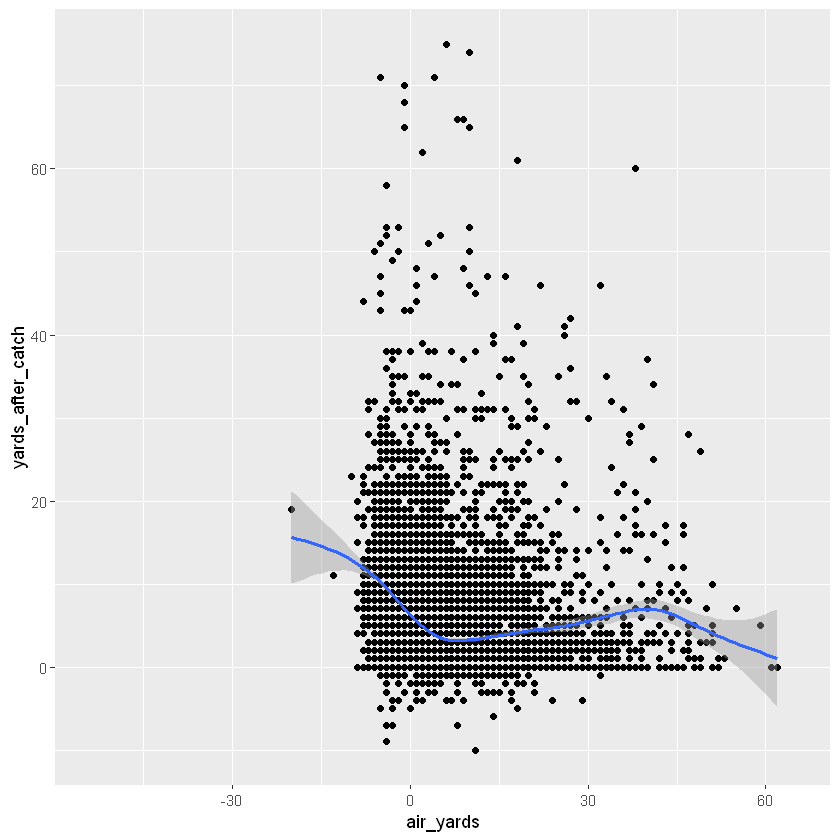

In [9]:
library(ggplot2)
ggplot(df, aes(air_yards, yards_after_catch)) + geom_point() + geom_smooth()

Notice here that we had to call the _ggplot2_ package in R, and then use the standard ggplot commands, including which members of the _aesthetic_ we wanted to make. Here we had pass depth as the _x_ variable and yards after the catch as the _y_ variable. There wasn't much in the way of a relationship between the two variables, as many shorter passes were taken for big gains after the catch, while many long passes had no or little yards after the catch. We can make this plot look at little better using the following code:

`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 37947 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 37947 rows containing missing values (geom_point)."

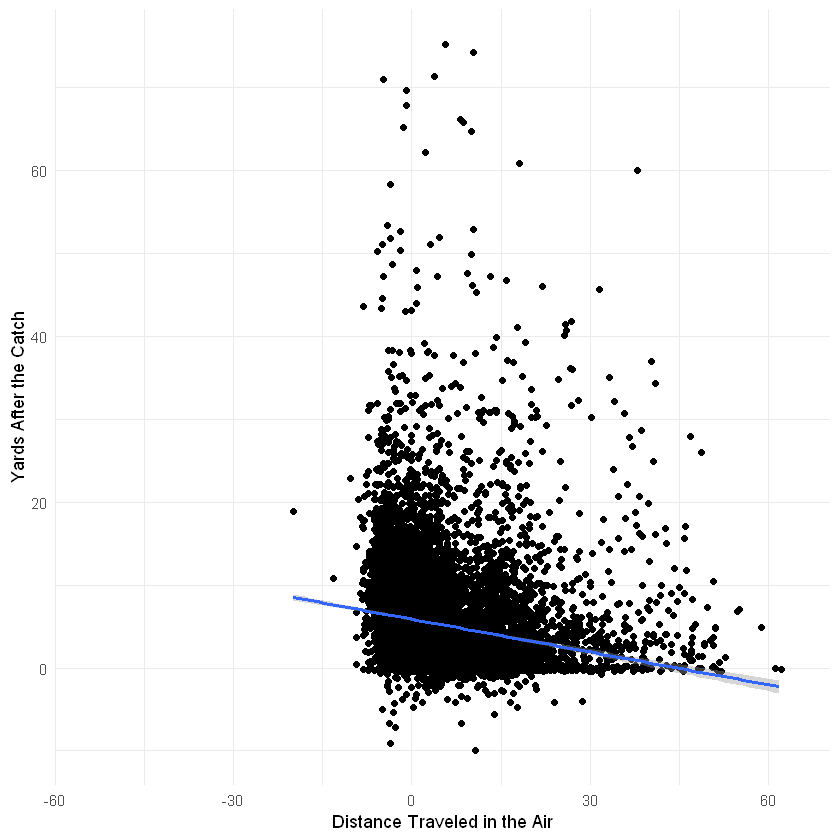

In [3]:
ggplot(df, aes(air_yards, yards_after_catch)) + geom_jitter() + geom_smooth(method = "lm") + theme_minimal() + labs(x = "Distance Traveled in the Air", y = "Yards After the Catch")

Here, if we look at the _linear_ relationship between the two variables, however small, we see that it is indeed negative. To get an idea of what the magnitude of that relationship is, we can look at the correlation coefficient between the two, using the following code:

In [7]:
cor(df$air_yards, df$yards_after_catch, use="complete.obs")

[1] -0.1703302

This isn't a big number, but it also isn't zero. Notice that we had to use the argument _use = "complete.obs"_ here because there are some passes that don't have a depth (like throwaways or spikes) or don't have a yards after catch reading (like incompletions). 

Let's see if this relationship holds if we aggregate at the player level for the 2022 NFL season. To do this, we use the following code from the _dplyr_ package:

In [8]:
nfl_qb_2022 <- df %>% group_by(season, passer_id, passer) %>% summarize(n = n(), air_yards = mean(air_yards, na.rm = TRUE), 
                                                                       yards_after_catch = mean(yards_after_catch, na.rm = TRUE))

head(nfl_qb_2022)

`summarise()` has grouped output by 'season', 'passer_id'. You can override using the `.groups` argument.


season,passer_id,passer,n,air_yards,yards_after_catch
2022,00-0019596,T.Brady,873,6.663317,4.748571
2022,00-0022824,A.Lee,1,0.000000,4.000000
2022,00-0023459,A.Rodgers,621,8.038889,5.385714
2022,00-0026143,M.Ryan,534,6.006522,4.585761
2022,00-0026158,J.Flacco,212,7.947644,4.118182
2022,00-0026197,C.Henne,9,3.111111,2.400000


Ok, this is cool. We immediately see the greatest player in league history, Tom Brady, here. We also see another Michigan legend, though, in Chiefs backup quarterback (and two-time Super Bowl champion) Chad Henne. We probably don't want such low-sample players here, as they will skew the data with noise. Let's filter out players with less than 100 passing plays in the 2022 season, and plot the relationship that is left over:

`geom_smooth()` using formula 'y ~ x'


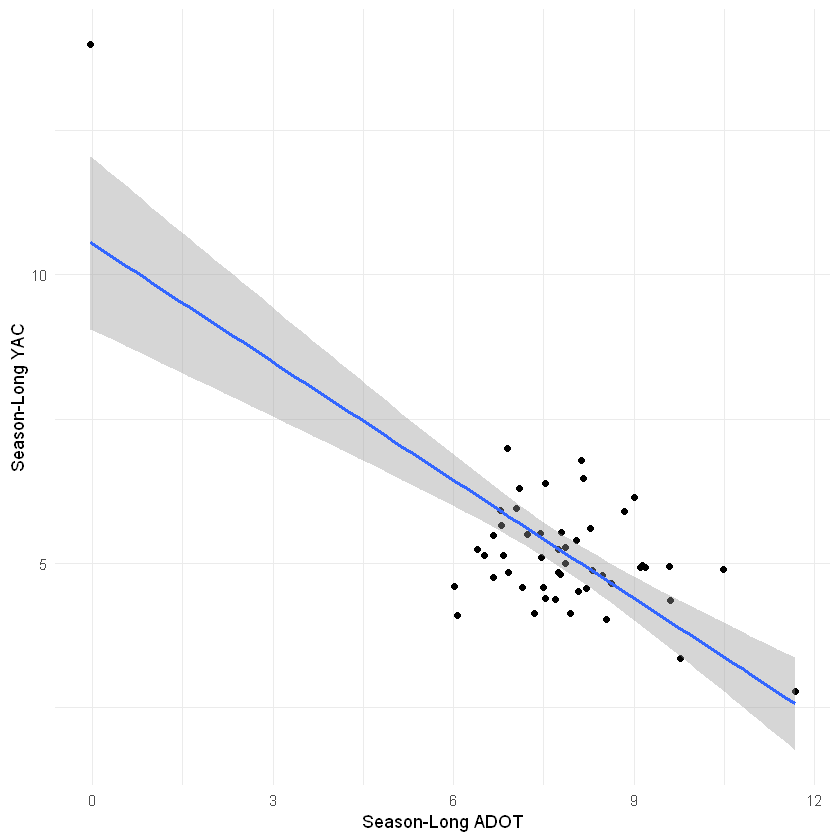

In [10]:
nfl_qb_2022 <- nfl_qb_2022 %>% filter(n >= 100)
ggplot(nfl_qb_2022, aes(air_yards, yards_after_catch)) + geom_point() + 
geom_smooth(method = "lm") + theme_minimal() + labs(x = "Season-Long ADOT", y = "Season-Long YAC")

Ok, now the negative relationship is much more definitive! Let's look at the correlation between these two variables:

In [11]:
cor(nfl_qb_2022$air_yards, nfl_qb_2022$yards_after_catch)

[1] -0.723959

This is much bigger. Hence, and we'll get back to this idea in a second, when aggregated to the season level, average depth of target and yards after the catch per completed pass are less two variables than they are "one-and-a-half variables". One thing that is interesting is looking at the two extremes on the graph.  Let's do that: 

`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 1 rows containing missing values (geom_text)."

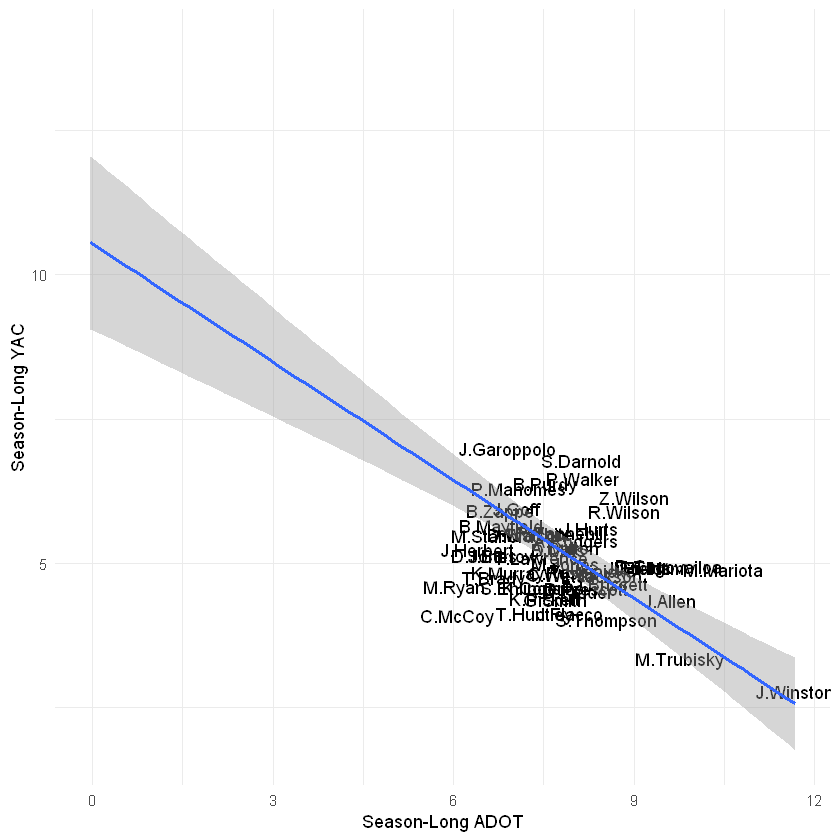

In [12]:
ggplot(nfl_qb_2022, aes(air_yards, yards_after_catch, label = passer)) + geom_text() + 
geom_smooth(method = "lm") + theme_minimal() + labs(x = "Season-Long ADOT", y = "Season-Long YAC")

Jimmy Garoppolo plays in an offense that allows him to get rid of the ball quickly and shortly, with great players running with it after the catch. Jameis Winston, who once led the entire league in passing yards in 2019, was on the other side of the spectrum, throwing the longest passes in the league until his benching in favor of Andy Dalton. 

Future work, should you choose to take it on, would be to see how _stable_ average depth of target and yards after the catch are from year to year for quarterbacks. Are these things that oscillate significantly from one season to the next? Or are they something that is characteristic of a quarterback - data that has a high correlation from one season to the next? 

You'll need the full data from _nflfastR_ to do this analysis, which you can find here: https://www.nflfastr.com/

### Time for Questions/Break

## Regression Modeling

Exploratory data analysis can get you a decent ways in football analytics and analytics in general, allowing you to learn more about not only the data representing the system you're studying but the system itself. 

However, in order to make processes _repeatable_, whether they be data wrangling, monitoring or prediction processes, a robust modeling framework is required. One such process is regression. 

In statistics and machine learning, _regression_ analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome' or 'response' variable, or a 'label') and one or more independent variables (often called 'predictors', 'covariates', 'explanatory variables' or 'features'). 

The most common form of regression analysis is _linear regression_, in which one finds the line (or, in higher dimensions, linear object) that most closely fits the data.

In this workshop, we're going to adjust rushing yards gained on a play by the play-level features that could affect them. In sports analytics, this is often called _normalizing_ the data for situation, or _context_. For rushing yards gained, the number of variables that could influence the end result are seemingly endless. However, for right now, let's just look at the yards needed for a first down or touchdown, which in the dataset is the column _ydstogo_:

`geom_smooth()` using formula 'y ~ x'


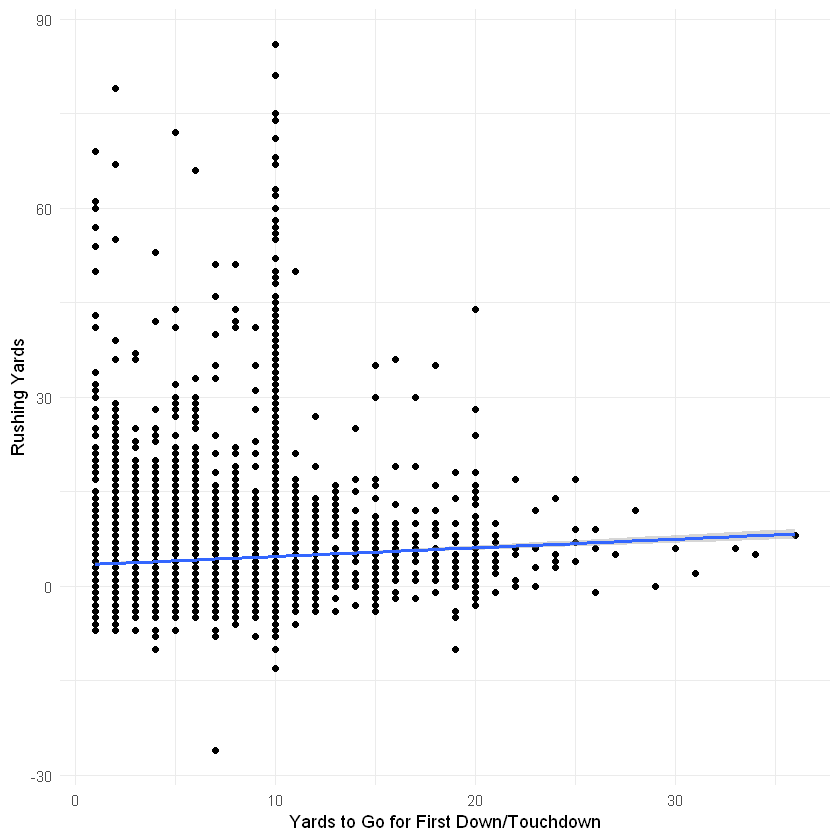

In [16]:
# first, we filter only to run plays
df_run <- df %>% filter(play_type == "run", !is.na(rusher_id), !is.na(rushing_yards))

ggplot(df_run, aes(ydstogo, rushing_yards)) + geom_point() + geom_smooth(method = "lm") + 
theme_minimal() + labs(x = "Yards to Go for First Down/Touchdown", y = "Rushing Yards")

There looks to be a small positive relationship here! Why is that (for the football knowers in the room)?

Thus, it's reasonable to assume a linear relationship between yards to go for a first down and rushing yards gained on a play. To model this, we need the following snippet of code from R:

In [17]:
fit_run <- lm(rushing_yards ~ ydstogo, data = df_run)

Here, _rushing_yards_ is the response variable, followed by _~_ to denote that the response variable depends on what follows, which is _ydstogo_. The final argument is the dataset that is used to _train_ the model. 

Now, we can look at the model to determine if the relationship is significant, and how much each yard to go is worth in terms of _expected rushing yards_ on average:

In [19]:
summary(fit_run)


Call:
lm(formula = rushing_yards ~ ydstogo, data = df_run)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.315  -3.388  -1.452   1.274  81.274 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.35431    0.12199  27.497   <2e-16 ***
ydstogo      0.13722    0.01403   9.784   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.316 on 14044 degrees of freedom
Multiple R-squared:  0.006769,	Adjusted R-squared:  0.006699 
F-statistic: 95.72 on 1 and 14044 DF,  p-value: < 2.2e-16


Notice, the p-value (which is the likelihood of obtaining the results of this regression, or something more extreme, if the relationship between rushing yards and yards to go for a first down was not actually apparent) is less than 10^(-16). Furthermore, it looks like each yard to go for a first down/touchdown adds about 0.14 yards per carry to the ballcarrier. This is not insignificant. If one runner ran on first down and 10 yards to go on each of their carries, and another on third down and one yard to go on each of there's, the difference in yards per carry would be expected to be (everything else equal, which they aren't) 1.2 yards. This is huge.

Is this the best we can do, though? Let's look at our data again and create a different color for each down:

`geom_smooth()` using formula 'y ~ x'


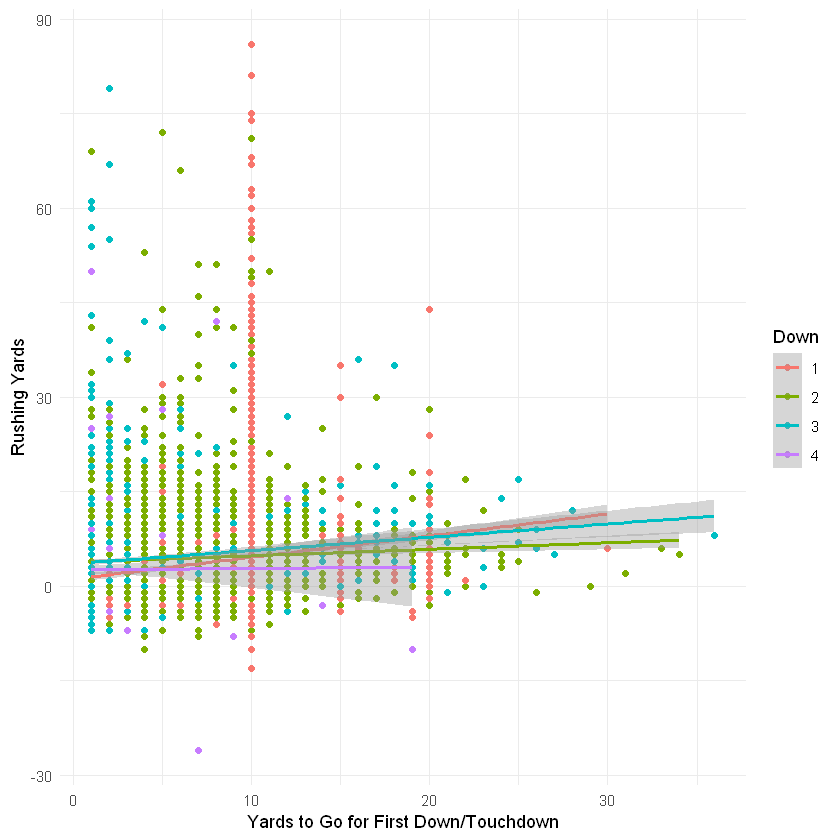

In [20]:
ggplot(df_run, aes(ydstogo, rushing_yards, color = as.factor(down))) + geom_point() + geom_smooth(method = "lm") + 
theme_minimal() + labs(x = "Yards to Go for First Down/Touchdown", y = "Rushing Yards", color = "Down")

Notice that there are different slopes for different downs! In fact, for fourth downs, there doesn't appear to be much in the way of a relationship between rushing yards gained and yards to go for a first down. Let's add down to the model as a factor variable, and let's use an interaction term between down and distance to go for a first down:

In [21]:
fit_run <- lm(rushing_yards ~ (as.factor(down) + ydstogo)^2, data = df_run)
summary(fit_run)


Call:
lm(formula = rushing_yards ~ (as.factor(down) + ydstogo)^2, data = df_run)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.758  -3.315  -1.315   1.408  81.408 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.16674    0.37097   3.145  0.00166 ** 
as.factor(down)2          2.63092    0.41293   6.371 1.93e-10 ***
as.factor(down)3          2.38693    0.42487   5.618 1.97e-08 ***
as.factor(down)4          1.43473    0.60325   2.378  0.01740 *  
ydstogo                   0.34253    0.03741   9.157  < 2e-16 ***
as.factor(down)2:ydstogo -0.23911    0.04467  -5.353 8.78e-08 ***
as.factor(down)3:ydstogo -0.13165    0.05201  -2.531  0.01138 *  
as.factor(down)4:ydstogo -0.32023    0.18666  -1.716  0.08627 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.303 on 14038 degrees of freedom
Multiple R-squared:  0.01127,	Adjusted R-squared:  0.01077 
F-statistic: 22.85 on 7 and 

Ok, let's apply this model to our dataset, as _exp_rushing_yards_, and take the residual, calling it rushing yards over expected (RYOE):

In [23]:
df_run[, "exp_rushing_yards"] <- predict(fit_run, df_run)
df_run[, "RYOE"] <- df_run$rushing_yards - df_run$exp_rushing_yards

Let's look at the leaders in total rushing yards and rushing yards over expected (RYOE) during the 2022 season:

In [25]:
df_run %>% group_by(season, rusher_id, rusher) %>% summarize(n = n(), rushing_yards = sum(rushing_yards), RYOE = sum(RYOE)) %>% 
arrange(-RYOE) %>% head(15)

`summarise()` has grouped output by 'season', 'rusher_id'. You can override using the `.groups` argument.


season,rusher_id,rusher,n,rushing_yards,RYOE
2022,00-0034796,L.Jackson,73,571,264.31088
2022,00-0036973,T.Etienne,250,1296,202.68304
2022,00-0033293,A.Jones,213,1121,171.69651
2022,00-0034791,N.Chubb,302,1525,160.72386
2022,00-0033357,T.Hill,96,575,159.14017
2022,00-0035700,J.Jacobs,340,1653,157.00262
2022,00-0036945,J.Fields,85,510,141.48394
2022,00-0036906,K.Herbert,129,731,138.68822
2022,00-0035261,T.Pollard,214,1106,133.11017
2022,00-0033280,C.McCaffrey,284,1377,115.25479


Lamar Jackson, who is currently in a contract dispuit with the Baltimore Ravens, led the NFL last year in total rushing yards over expected, and by quite a bit. These were all generated from the quarterback position, and on _designed runs_, not passing plays that broke down into a run. Notice we do see some other quarterbacks on this list as well, Taysom Hill of the Saints and Justin Fields of the Bears. First-year players Travis Etienne (who missed his rookie season with an injury), Isiah Pacheco, Tyler Allgeier and Breece Hall appear, as do franchise tag players Josh Jacobs and Tony Pollard. 

Christian McCaffrey is currently the highest-paid running back in the NFL and was recently traded to the 49ers for multiple draft picks. Adjusting for situation appears to have ranked the players differently. For more on RYOE, see the following: https://www.nfl.com/news/next-gen-stats-intro-to-expected-rushing-yards

### Time for Questions/Break

Now, we stay on the regression topic to talk about the NFL Draft, which recently took place in Kansas City, MO. We look at drafts from 2000 to 2019 for insights in how well teams draft players, after _controlling_ for draft position.

Here, we read in draft data from _Pro Football Reference_, and look at the first few records of the data:

In [11]:
library(dplyr)
setwd("C:/Users/eric/Dropbox/PC (2)/Documents")
df <- read.csv("nfl_draft_data.csv")
head(df)

Season,Rnd,Pick,Player,Tm,Position,Age,College,To,AP1,PB,St,wAV,DrAV,G
2000,1,1,Courtney Brown,CLE,DE,22,Penn St.,2005,0,0,4,27,21,61
2000,1,2,LaVar Arrington,WAS,LB,22,Penn St.,2006,0,3,5,46,45,85
2000,1,3,Chris Samuels,WAS,T,23,Alabama,2009,0,6,9,63,63,141
2000,1,4,Peter Warrick,CIN,WR,23,Florida St.,2005,0,0,4,27,25,79
2000,1,5,Jamal Lewis,BAL,RB,21,Tennessee,2009,1,1,9,69,53,131
2000,1,6,Corey Simon,PHI,DT,23,Florida St.,2007,0,1,6,45,41,95


Here, we have the first six picks of the 2000 NFL Draft. Let's look at the tail of the data:

In [12]:
tail(df)

,Season,Rnd,Pick,Player,Tm,Position,Age,College,To,AP1,PB,St,wAV,DrAV,G
5090,2019,7,249,Michael Dogbe,ARI,DE,23,Temple,2022,0,0,0,4,4,40
5091,2019,7,250,Austin Cutting,MIN,LS,22,Air Force,2020,0,0,0,1,1,25
5092,2019,7,251,Dakota Allen,LAR,LB,23,Texas Tech,2022,0,0,0,2,NA,38
5093,2019,7,252,Ken Webster,NWE,CB,23,Mississippi,2020,0,0,0,3,NA,17
5094,2019,7,253,Jordan Brailford,WAS,DE,23,Oklahoma St.,2020,0,0,0,1,NA,5
5095,2019,7,254,Caleb Wilson,ARI,TE,23,UCLA,2020,0,0,0,0,NA,5


The question we want to ask in this workshop is "are some NFL teams better or worse at drafting than others, after adjusting for draft position?". The last part, adjusting for draft position, requires some work. The variable we're going to look at is _DrAV_, which is the Approximate Value (as derived by Pro Football Reference) earned for the team that drafted the player. Approximate Value takes into consideration things like games played, statistics generated, team success, and other measures that comprehensively assess the success of a player during a given season and, when aggregated, career. Let's look at how this value tails off with respect to draft position:

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


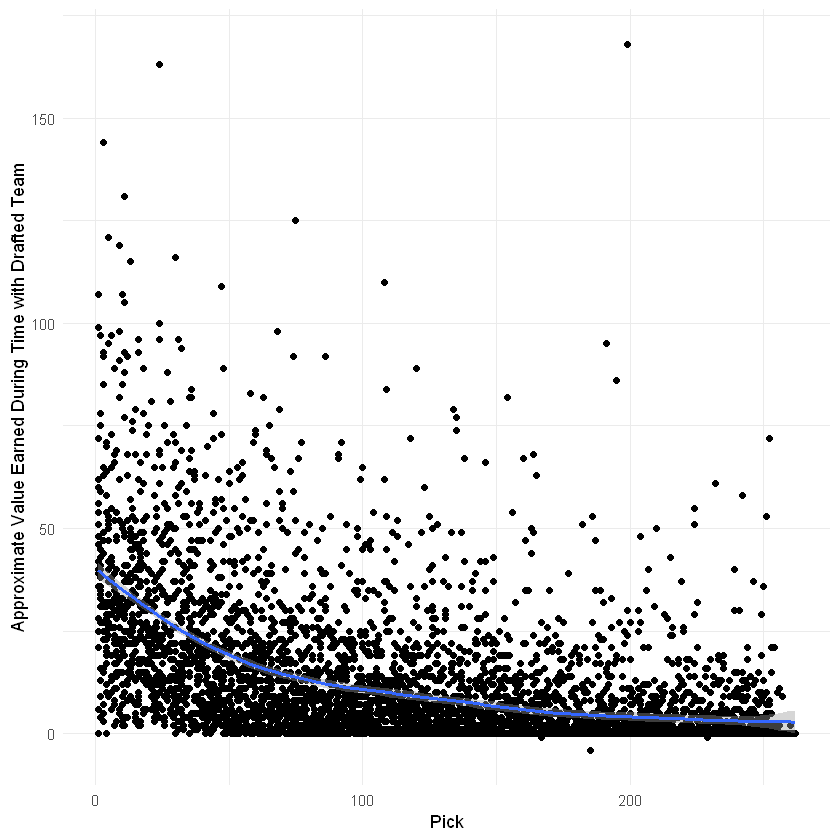

In [14]:
# let's make players with NA in terms of approximate value have a zero value
df$DrAV[is.na(df$DrAV)] <- 0
ggplot(df, aes(Pick, DrAV)) + geom_point() + geom_smooth() + theme_minimal() + 
labs(x = "Pick", y = "Approximate Value Earned During Time with Drafted Team")

Ok, so this is what you'd expect from a functioning league, draft pick value decreasing as the draft goes on. This decline, however, does not appear linear, but rather something more exponential. So, we use our mathematical modeling from the previous section not on _DrAV_, but on the natural logarithm in _DrAV_. Doing so:

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


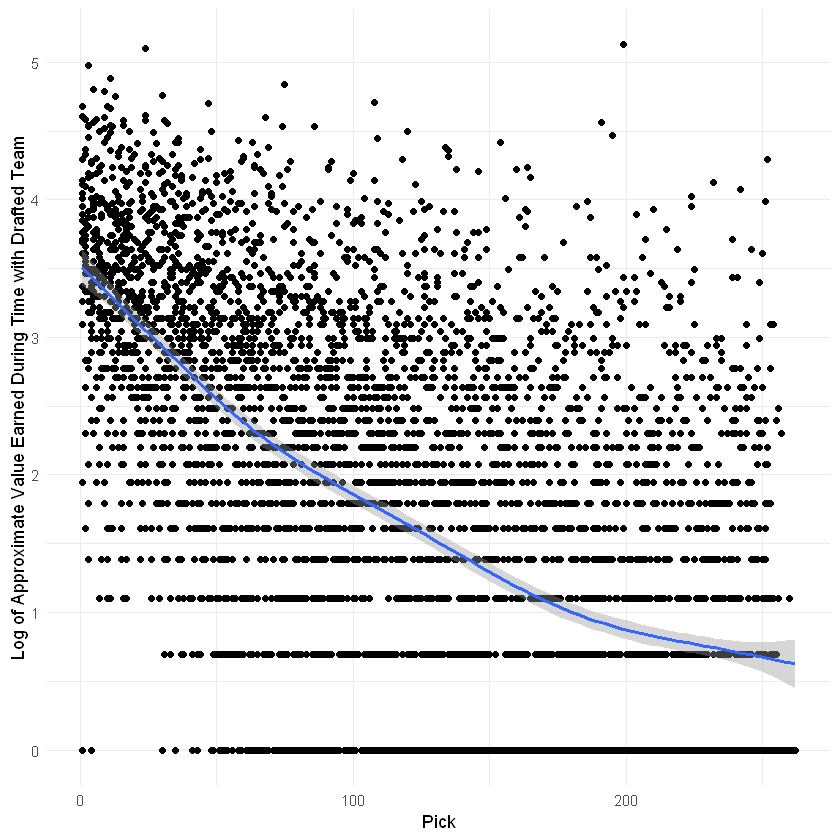

In [43]:
ggplot(df, aes(Pick, log(pmax(DrAV, 0) + 1))) + geom_point() + geom_smooth() + theme_minimal() + 
labs(x = "Pick", y = "Log of Approximate Value Earned During Time with Drafted Team")

In [31]:
fit_DrAV <- lm(DrAV ~ Pick, data = df %>% mutate(DrAV = log(pmax(DrAV, 0) + 1)))
summary(fit_DrAV)


Call:
lm(formula = DrAV ~ Pick, data = df %>% mutate(DrAV = log(pmax(DrAV, 
    0) + 1)))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1072 -0.7990 -0.0393  0.7657  4.2199 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.1183371  0.0307650  101.36   <2e-16 ***
Pick        -0.0110972  0.0002085  -53.22   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.095 on 5093 degrees of freedom
Multiple R-squared:  0.3574,	Adjusted R-squared:  0.3573 
F-statistic:  2832 on 1 and 5093 DF,  p-value: < 2.2e-16


This isn't an awful fit, as about 36 percent of the variance in the log of the output is influenced by the pick in which a player went in the draft. Let's apply it to our data:

Season,Rnd,Pick,Player,Tm,Position,Age,College,To,AP1,PB,St,wAV,DrAV,G,exp_DrAV
2000,1,1,Courtney Brown,CLE,DE,22,Penn St.,2005,0,0,4,27,21,61,21.35924
2000,1,2,LaVar Arrington,WAS,LB,22,Penn St.,2006,0,3,5,46,45,85,21.11249
2000,1,3,Chris Samuels,WAS,T,23,Alabama,2009,0,6,9,63,63,141,20.86846
2000,1,4,Peter Warrick,CIN,WR,23,Florida St.,2005,0,0,4,27,25,79,20.62712
2000,1,5,Jamal Lewis,BAL,RB,21,Tennessee,2009,1,1,9,69,53,131,20.38845
2000,1,6,Corey Simon,PHI,DT,23,Florida St.,2007,0,1,6,45,41,95,20.15241


,Season,Rnd,Pick,Player,Tm,Position,Age,College,To,AP1,PB,St,wAV,DrAV,G,exp_DrAV
5090,2019,7,249,Michael Dogbe,ARI,DE,23,Temple,2022,0,0,0,4,4,40,0.4263680
5091,2019,7,250,Austin Cutting,MIN,LS,22,Air Force,2020,0,0,0,1,1,25,0.4106268
5092,2019,7,251,Dakota Allen,LAR,LB,23,Texas Tech,2022,0,0,0,2,0,38,0.3950593
5093,2019,7,252,Ken Webster,NWE,CB,23,Mississippi,2020,0,0,0,3,0,17,0.3796636
5094,2019,7,253,Jordan Brailford,WAS,DE,23,Oklahoma St.,2020,0,0,0,1,0,5,0.3644378
5095,2019,7,254,Caleb Wilson,ARI,TE,23,UCLA,2020,0,0,0,0,0,5,0.3493801


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


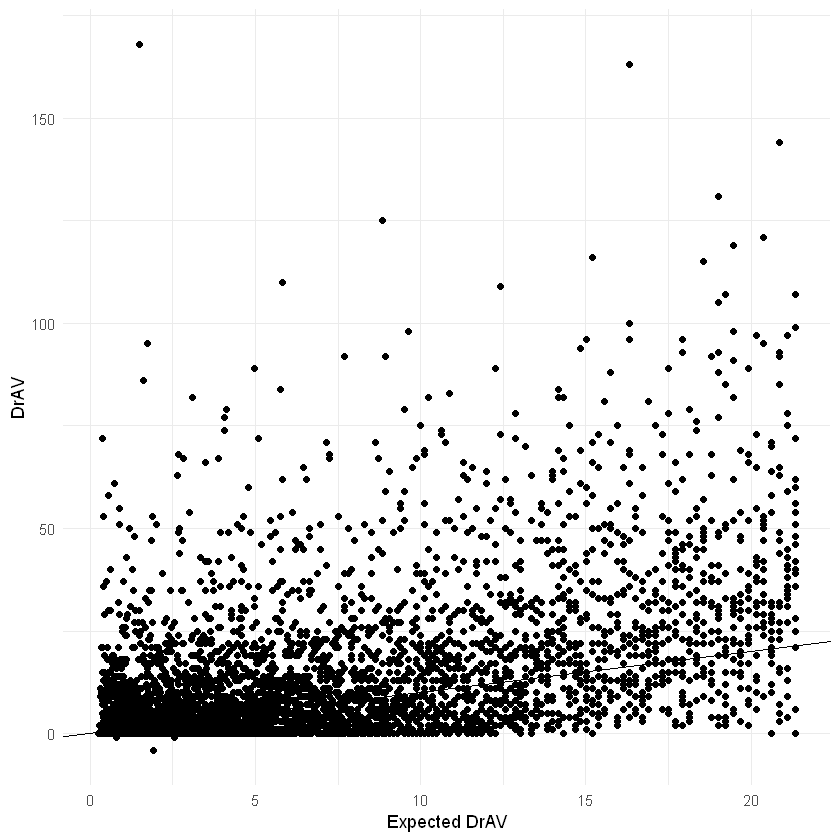

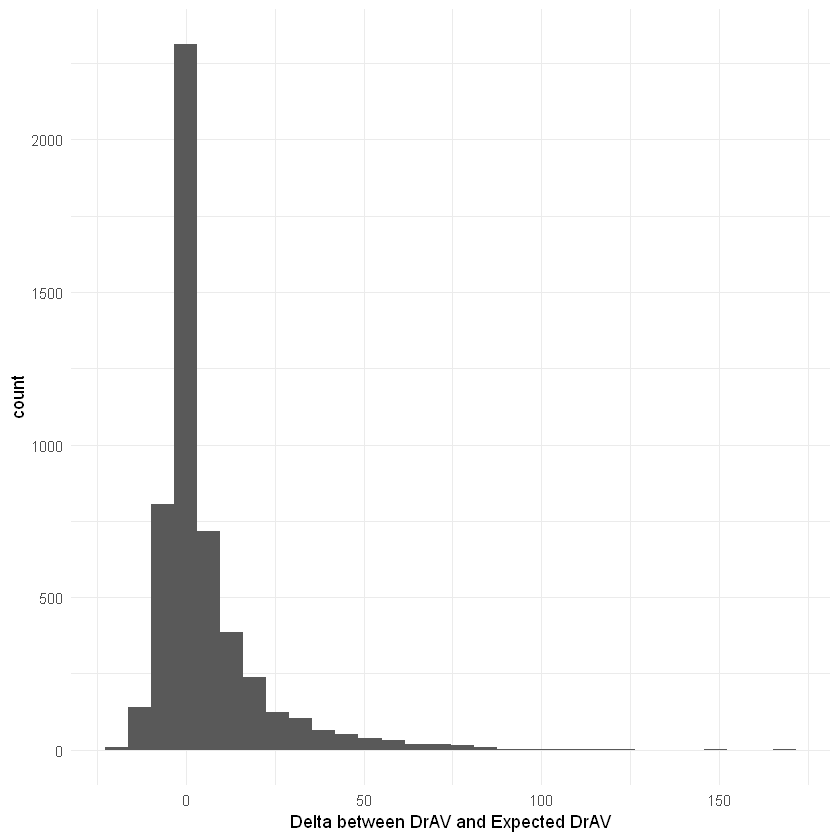

In [25]:
df[, "exp_DrAV"] <- exp(predict(fit_DrAV,df)) - 1
head(df)
tail(df)
ggplot(df, aes(exp_DrAV, DrAV)) + geom_point() + geom_abline() + theme_minimal() + labs(x = "Expected DrAV", y = "DrAV") 
ggplot(df, aes(DrAV - exp_DrAV)) + geom_histogram() + theme_minimal() + labs(x = "Delta between DrAV and Expected DrAV")

The errors are a bit right-skewed, in large part because the data is a bit right-skewed in the first place. There are some other things we can do to transform the data and get better results, but they are beyond the scope of this workshop. Let's take the average difference between logarithm of the pick and its expectation across the last two decades:

In [36]:
group_by(df, Tm) %>% 
summarize(n = n(), mean_Diff = mean(log(pmax(DrAV,0) + 1) - log(pmax(exp_DrAV, 0) + 1)), 
          sd_Diff = sd(log(pmax(DrAV,0) + 1) - log(pmax(exp_DrAV, 0) + 1))) %>% 
mutate(SE = sd_Diff/sqrt(n)) %>%
arrange(-mean_Diff)

Tm,n,mean_Diff,sd_Diff,SE
LAC,21,0.562657663,0.8795288,0.19192891
LAR,33,0.349284145,0.8353395,0.14541394
IND,162,0.180684107,1.1537662,0.09064844
ATL,148,0.159349609,1.0611524,0.08722619
GNB,180,0.137389994,1.2507148,0.09322278
TEN,172,0.095877804,1.0359953,0.07899390
SEA,181,0.080629906,1.1116402,0.08262756
CHI,149,0.072722456,1.1378051,0.09321263
SDG,123,0.072288954,1.1120089,0.10026647
BAL,170,0.071942678,1.0747608,0.08243039


We created standard errors so that we could answer the question above - whether or not teams are better or worse than average in terms of their drafting. However, there are some issues here that come up. Namely, that there are teams that switched cities and hence abbreviations. Let's combine them. Additionally, let's add an upper and lower bound to our estimate for the log difference between their drafting and expectation:

In [41]:
df %>% mutate(Tm = as.character(Tm), Tm = case_when(Tm == "SDG" ~ "LAC", 
                                   Tm == "STL" ~ "LAR", 
                                   Tm == "OAK" ~ "LVR", 
                                   TRUE ~ Tm)) %>%
group_by(Tm) %>% 
summarize(n = n(), mean_Diff = mean(log(pmax(DrAV,0) + 1) - log(pmax(exp_DrAV, 0) + 1)), 
          sd_Diff = sd(log(pmax(DrAV,0) + 1) - log(pmax(exp_DrAV, 0) + 1))) %>% 
mutate(SE = sd_Diff/sqrt(n)) %>%
mutate(Lower = mean_Diff - 1.96*SE, Upper = mean_Diff + 1.96*SE) %>%
arrange(-mean_Diff)

Tm,n,mean_Diff,sd_Diff,SE,Lower,Upper
IND,162,0.180684107,1.1537662,0.09064844,0.003013174,0.35835504
ATL,148,0.159349609,1.0611524,0.08722619,-0.011613717,0.33031294
LAC,144,0.143801057,1.0923942,0.09103285,-0.034623327,0.32222544
GNB,180,0.137389994,1.2507148,0.09322278,-0.045326654,0.32010664
TEN,172,0.095877804,1.0359953,0.07899390,-0.058950245,0.25070585
SEA,181,0.080629906,1.1116402,0.08262756,-0.081320119,0.24257993
CHI,149,0.072722456,1.1378051,0.09321263,-0.109974290,0.25541920
BAL,170,0.071942678,1.0747608,0.08243039,-0.089620882,0.23350624
JAX,158,0.055505119,1.0467845,0.08327770,-0.107719175,0.21872941
MIN,167,0.029817094,1.0195142,0.07889238,-0.124811969,0.18444616


Notice that there's only one team (the Colts) that have a lower bound above zero, so we're 95% confident they draft better than their draft position - in terms of the differences in the log of draft value. There's one other team that drafts worse than average, with their upper bound beneath zero, and that's the Cleveland Browns - who have made the playoffs twice since 1994 and haven't won their division since 1989.

Thus, for the most part, after adjusting for the expectation of the pick, there isn't a ton of evidence that teams are better than drafting (e.g. evaluating) players than other teams.

### Time for Questions/Break

## Dimensionality Reduction and Clustering

To close off this workshop, we will look at NFL Scouting Combine data as the basis for dimensionality reduction and clustering. Dimensionality reduction takes data that is _column rich_ and reduces the number of columns by finding - in the case of _pinciple component analysis_ - linear relationships between variables. Once this is done, the process of clustering groups individuals into clusters that are not determined _a priori_, as a part of what is called _unsupervised learning_. 

Let's take a look at our NFL Scouting Combine data, courtosy of Pro Football Reference:

In [71]:
df <- read.csv("nfl_combine_data.csv")
head(df)
tail(df)

Season,Player,Pos,School,Ht,Wt,Forty,Vertical,Bench,Broad,Three_Cone,Shuttle
2000,John Abraham,OLB,South Carolina,76,252,4.55,NA,NA,NA,NA,NA
2000,Shaun Alexander,RB,Alabama,72,218,4.58,NA,NA,NA,NA,NA
2000,Darnell Alford,OT,Boston Col.,76,334,5.56,25,23,94,8.48,4.98
2000,Kyle Allamon,TE,Texas Tech,74,253,4.97,29,NA,104,7.29,4.49
2000,Rashard Anderson,CB,Jackson State,74,206,4.55,34,NA,123,7.18,4.15
2000,Jake Arians,K,Ala-Birmingham,70,202,NA,NA,NA,NA,NA,NA


,Season,Player,Pos,School,Ht,Wt,Forty,Vertical,Bench,Broad,Three_Cone,Shuttle
7994,2023,Rejzohn Wright,CB,Oregon St.,74,193,NA,NA,NA,NA,NA,NA
7995,2023,Luke Wypler,C,Ohio St.,75,303,5.14,30.5,NA,106,7.64,4.53
7996,2023,Bryce Young,QB,Alabama,70,204,NA,NA,NA,NA,NA,NA
7997,2023,Byron Young,EDGE,Tennessee,74,250,4.43,38.0,22,132,7.19,NA
7998,2023,Byron Young,DT,Alabama,75,294,NA,26.0,24,108,7.68,NA
7999,2023,Cameron Young,DT,Mississippi St.,75,304,5.10,NA,NA,NA,NA,NA


Here, you have the year in which the player performed in the combine, the player's name and position, their college, height (in inches), weight (in pounds), how fast they ran the forty-yard dash (in seconds), how high they jumped the vertical jump (in inches), how many times they bench pressed 225 pounds, how far they jumped in the broad jump (in inches), how well they ran the three-cone drill (in seconds) and the short shuttle (in seconds). Let's get a look at the data:

In [53]:
summary(df)

     Season                  Player          Pos              School    
 Min.   :2000   Chris Brown     :   6   WR     :1113   Alabama   : 191  
 1st Qu.:2006   Brandon Williams:   4   CB     : 798   LSU       : 188  
 Median :2012   Brian Allen     :   4   RB     : 699   Florida   : 177  
 Mean   :2012   Chris Jones     :   4   S      : 563   Georgia   : 175  
 3rd Qu.:2018   Josh Johnson    :   4   OT     : 548   Ohio State: 163  
 Max.   :2023   Mike Williams   :   4   DE     : 528   USC       : 160  
                (Other)         :7973   (Other):3750   (Other)   :6945  
       Ht             Wt            Forty          Vertical         Bench      
 Min.   :64.0   Min.   :144.0   Min.   :4.220   Min.   :17.50   Min.   : 2.00  
 1st Qu.:72.0   1st Qu.:205.0   1st Qu.:4.530   1st Qu.:30.00   1st Qu.:16.00  
 Median :74.0   Median :232.0   Median :4.690   Median :33.00   Median :21.00  
 Mean   :73.8   Mean   :242.6   Mean   :4.774   Mean   :32.93   Mean   :20.74  
 3rd Qu.:76.0   

The thing that's interesting is that there are a lot of NA's. More NA's for things like the three-cone drill and the shuttle than things like the 40-yard dash or a player's height and weight measurements. If we are going to do actual analysis we have to resolve these NA's. We do so by first filtering out players without a height and weight, and using k-nearest neighbors to "fill in" the rest of the spots based on the rest of the player's data.

In [74]:
library("DMwR2")
df <- df %>% filter(!is.na(Ht), !is.na(Wt))
df_knn <- knnImputation(df %>% select(Ht:Shuttle) %>%
                          mutate(seq = 1:nrow(df)) %>% as.data.frame(),
                        k = 10, scale = TRUE, meth = "median")
df <- cbind(df %>% select(Season:School), df_knn) %>% select(-seq)
summary(df)


Warning message in knnImputation(df %>% select(Ht:Shuttle) %>% mutate(seq = 1:nrow(df)) %>% :
"No case has missing values. Stopping as there is nothing to do."

     Season                  Player          Pos              School    
 Min.   :2000   Chris Brown     :   6   WR     :1108   LSU       : 188  
 1st Qu.:2006   Brandon Williams:   4   CB     : 798   Alabama   : 187  
 Median :2012   Brian Allen     :   4   RB     : 697   Florida   : 177  
 Mean   :2012   Chris Jones     :   4   S      : 559   Georgia   : 175  
 3rd Qu.:2018   Josh Johnson    :   4   OT     : 548   Ohio State: 163  
 Max.   :2023   Mike Williams   :   4   DE     : 528   USC       : 159  
                (Other)         :7944   (Other):3732   (Other)   :6921  
       Ht             Wt            Forty          Vertical         Bench     
 Min.   :64.0   Min.   :144.0   Min.   :4.220   Min.   :17.50   Min.   : 2.0  
 1st Qu.:72.0   1st Qu.:205.0   1st Qu.:4.540   1st Qu.:30.50   1st Qu.:16.0  
 Median :74.0   Median :232.0   Median :4.680   Median :33.50   Median :20.0  
 Mean   :73.8   Mean   :242.5   Mean   :4.771   Mean   :32.95   Mean   :20.1  
 3rd Qu.:76.0   3rd Q

Ok, so we no longer have missing values. Great. Now, for the reason we're doing this thing. Inspect the relationship between some of these variables.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


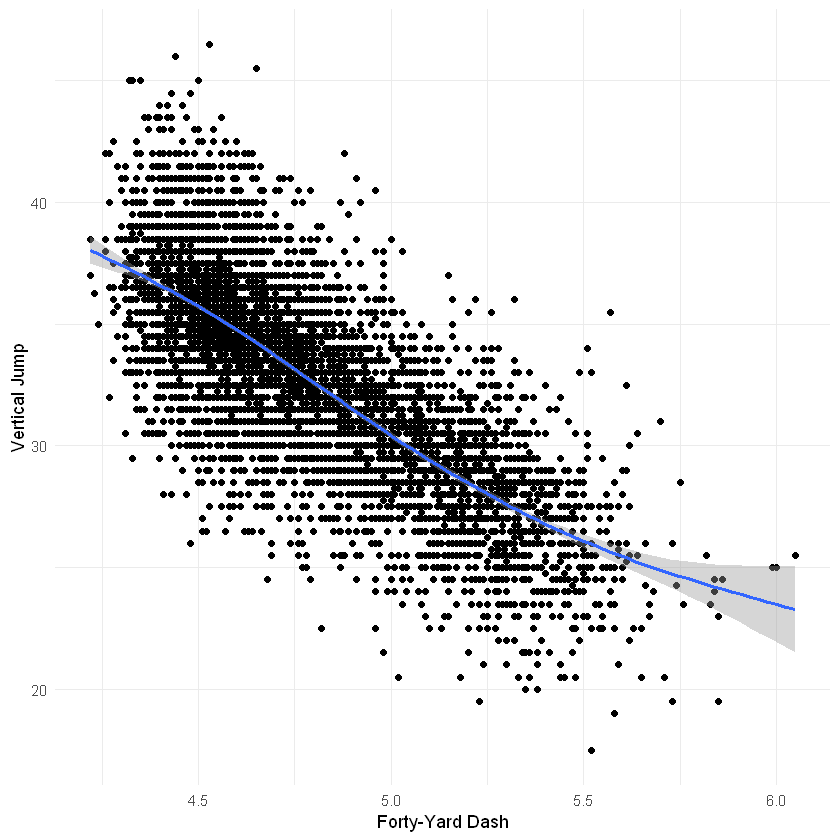

In [55]:
ggplot(df, aes(Forty, Vertical)) + geom_point() + geom_smooth() + theme_minimal() + labs(x = "Forty-Yard Dash", y = "Vertical Jump")

Thus, forty-yard dash and vertical jump are not two, independent pieces of information. Let's look at one more, the three-cone and short shuttle:

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


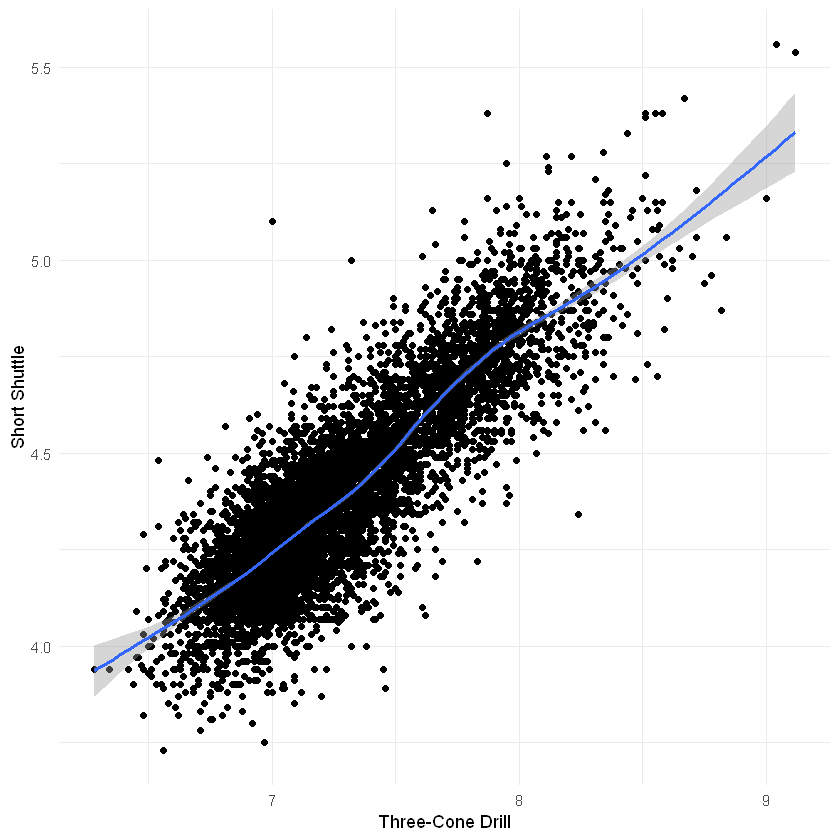

In [56]:
ggplot(df, aes(Three_Cone, Shuttle)) + geom_point() + geom_smooth() + theme_minimal() + labs(x = "Three-Cone Drill", y = "Short Shuttle")

Thus, instead of having n actual pieces of information, we have something like m pieces of information, and m < n. To access this information, we use something like principle component analysis. 

Principle component analysis is a process that linearly transforms data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. For example, for a system with two variables, the two principle components are straight lines in the plane.

In R, we can perform this analysis the following way:

In [75]:
scaled_df <- scale(df %>% select(Ht:Shuttle))
pca_fit <- prcomp(scaled_df)

df <- cbind(df, pca_fit$x)

pca_fit$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Ht,-0.2807717,0.47755765,0.738522088,-0.215019140,0.05950544,-0.13052799,-0.18932662,0.21221413
Wt,-0.3911712,0.27280260,0.007027534,0.044644859,-0.13829507,0.17326763,0.14372938,-0.83708779
Forty,-0.3942123,-0.09767331,0.044832071,-0.002736506,-0.46521040,0.33704216,0.58580342,0.39981924
Vertical,0.3460512,0.41859928,-0.004032895,0.514131510,-0.56142458,-0.35059707,0.04120853,0.02935498
Bench,-0.2676030,0.60573750,-0.652755399,-0.176854028,0.17823905,-0.06007383,-0.03147522,0.26025957
Broad,0.3669482,0.33646453,0.141749874,0.339495067,0.43196885,0.60269141,0.25299868,0.05429872
Three_Cone,-0.3815484,-0.11313933,-0.059014320,0.519439407,-0.09932919,0.34604091,-0.64612096,0.14573077
Shuttle,-0.3757075,-0.14080195,0.053331347,0.520656665,0.46635048,-0.47941103,0.34082573,0.04013979


Notice that the first principle component (PC1) has negative weights for height, weight, forty, bench, three-cone and shuttle and positive weights for vertical and broad, the latter two you'd like to be bigger! We can see what this means by looking at some of the players:

In [76]:
head(df)

Season,Player,Pos,School,Ht,Wt,Forty,Vertical,Bench,Broad,Three_Cone,Shuttle,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
2000,John Abraham,OLB,South Carolina,76,252,4.55,35.00,21.5,118.0,7.045,4.260,0.6205005,1.1461092,0.47874726,-0.3670742,0.09375965,-0.24245651,-0.26564063,-0.29296007
2000,Shaun Alexander,RB,Alabama,72,218,4.58,36.75,16.0,116.0,7.010,4.260,1.6603856,-0.2501383,-0.04258179,0.1958969,-0.44377808,-0.40526279,0.02177608,-0.20682024
2000,Darnell Alford,OT,Boston Col.,76,334,5.56,25.00,23.0,94.0,8.480,4.980,-5.8745816,-1.3256758,0.03580462,0.9375417,-0.41931300,0.33837194,-0.26061853,0.04500497
2000,Kyle Allamon,TE,Texas Tech,74,253,4.97,29.00,21.0,104.0,7.290,4.490,-1.3972937,-0.7615766,-0.16395801,-0.6773637,-0.07334115,-0.30896007,0.14646296,0.06452347
2000,Rashard Anderson,CB,Jackson State,74,206,4.55,34.00,17.5,123.0,7.180,4.150,1.5684052,0.1931903,0.40274231,-0.1164880,0.20366078,0.48533054,-0.49710595,0.27259429
2000,Jake Arians,K,Ala-Birmingham,70,202,4.50,36.00,15.0,117.5,7.085,4.135,2.2752026,-0.7596441,-0.51598427,0.1703147,-0.42661177,0.03331882,-0.30222145,-0.21107515


Some of the players have positive values for PC1, some have negative values for PC1. This is what you want. Looking at a plot of PC1 and PC2:

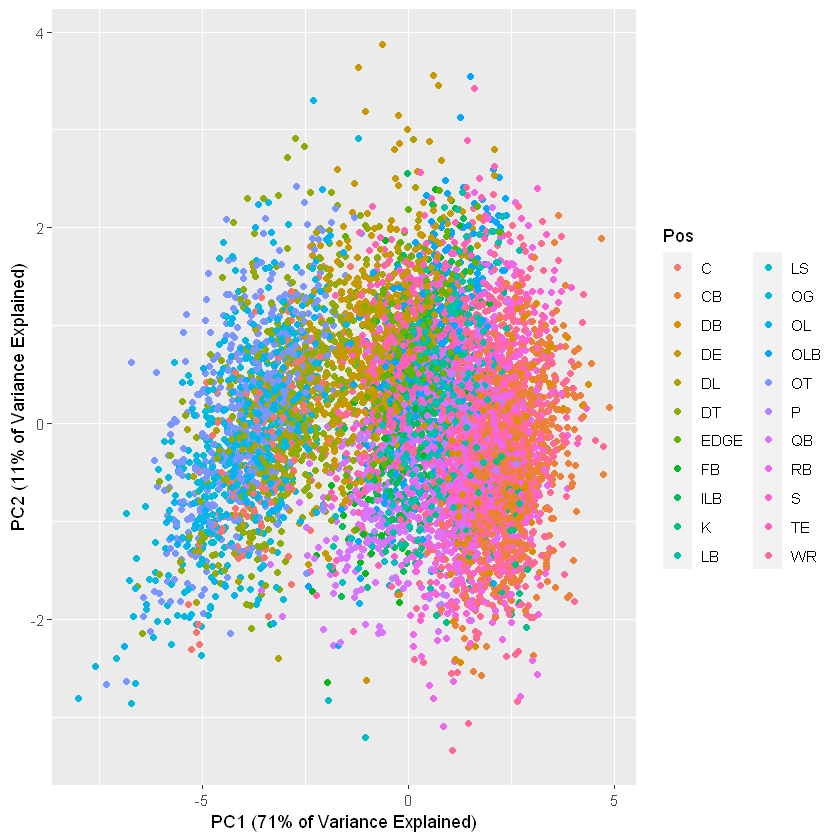

In [77]:
ggplot(df, aes(PC1, PC2, color = Pos)) + geom_point() + 
  labs(x = paste0("PC1 (", 100*round(pca_fit$sdev[1]^2/sum(pca_fit$sdev^2), 2), "% of Variance Explained)"), 
       y = paste0("PC2 (", 100*round(pca_fit$sdev[2]^2/sum(pca_fit$sdev^2), 2), "% of Variance Explained)"))


This is a pretty cool look at the groupings of players into different positions based on their athleticism and size traits. This screams "clustering". It's not necessarily clear how many clusters are necessary, but let's guess at six clusters. Here's the R course for doing this.

In [78]:
k_means_fit <- kmeans(df %>% select(PC1:PC2), centers = 6, iter.max = 10)

df$cluster <- k_means_fit$cluster
head(df)

Season,Player,Pos,School,Ht,Wt,Forty,Vertical,Bench,Broad,...,Shuttle,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,cluster
2000,John Abraham,OLB,South Carolina,76,252,4.55,35.00,21.5,118.0,...,4.260,0.6205005,1.1461092,0.47874726,-0.3670742,0.09375965,-0.24245651,-0.26564063,-0.29296007,1
2000,Shaun Alexander,RB,Alabama,72,218,4.58,36.75,16.0,116.0,...,4.260,1.6603856,-0.2501383,-0.04258179,0.1958969,-0.44377808,-0.40526279,0.02177608,-0.20682024,3
2000,Darnell Alford,OT,Boston Col.,76,334,5.56,25.00,23.0,94.0,...,4.980,-5.8745816,-1.3256758,0.03580462,0.9375417,-0.41931300,0.33837194,-0.26061853,0.04500497,5
2000,Kyle Allamon,TE,Texas Tech,74,253,4.97,29.00,21.0,104.0,...,4.490,-1.3972937,-0.7615766,-0.16395801,-0.6773637,-0.07334115,-0.30896007,0.14646296,0.06452347,4
2000,Rashard Anderson,CB,Jackson State,74,206,4.55,34.00,17.5,123.0,...,4.150,1.5684052,0.1931903,0.40274231,-0.1164880,0.20366078,0.48533054,-0.49710595,0.27259429,6
2000,Jake Arians,K,Ala-Birmingham,70,202,4.50,36.00,15.0,117.5,...,4.135,2.2752026,-0.7596441,-0.51598427,0.1703147,-0.42661177,0.03331882,-0.30222145,-0.21107515,3


k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. There are other ways to cluster, which are beyond the scope of this workshop, including model-based clustering, which has been used in football analytics to model tracking data: https://danichusfu.github.io/publication/route-identification-nfl/

Let's look at the positions for each cluster, as a proof of concept:

In [80]:
df %>% filter(cluster == 1) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
OLB,258,74.12016,241.6473
TE,247,76.47368,251.8826
DE,219,75.78082,263.7443
ILB,127,73.73228,242.2598
WR,116,75.61207,221.0345


In [81]:
df %>% filter(cluster == 2) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
DT,340,74.99412,304.6147
OT,237,77.62447,310.4726
OG,150,75.94000,308.9667
DE,143,76.36364,279.6923
C,101,75.35644,302.5842


In [83]:
df %>% filter(cluster == 3) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
WR,507,71.96252,196.8166
CB,408,70.90441,191.3529
RB,386,69.89119,209.0596
S,258,71.89535,204.7713
K,74,71.21622,189.5541


In [84]:
df %>% filter(cluster == 4) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
QB,244,74.72131,222.6557
TE,169,76.05917,254.2012
DE,164,75.23780,265.1159
ILB,129,73.03101,241.7132
OLB,123,73.38211,241.2114


In [85]:
df %>% filter(cluster == 5) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
OT,310,77.58065,318.6355
OG,268,76.06343,317.8321
DT,140,75.03571,316.3714
C,91,75.24176,303.9560
OL,70,76.38571,315.3000


In [86]:
df %>% filter(cluster == 6) %>% group_by(Pos) %>% summarize(n = n(), Ht = mean(Ht), Wt = mean(Wt)) %>%
  arrange(-n) %>% head(5)

Pos,n,Ht,Wt
WR,451,72.72949,200.9002
CB,383,71.65013,194.2820
S,252,72.38889,207.2381
RB,175,70.68000,212.2057
DB,34,71.76471,198.3235


These are pretty fun. Linemen with linemen, wide receivers with defensive backs and running backs. A quarterback/tight end cluster (similar body types and athleticisms). In future work, you'll want to mess around with the number of clusters, but this is a good start.

### Time for Questions/Break

Thank you for taking the time to learn some data science with me today, using American football as an example. If you have any more questions, you can email me at eric.eager@sumersports.com.